In [337]:
#================================================
# DATA
#================================================

import duckdb, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# creating the conection to the duckdb database file:
con = duckdb.connect("movielens100K.duckdb")

In [338]:
IMDB_DIR = Path("..") / "data" / "Imdb"
IMDB_DIR

WindowsPath('../data/Imdb')

### 1.0 Temporary Views to query Imdb File composition
#### 1.1 File "name.basics.tsv"

In [339]:
# Creating the view for the name.basics file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_name_basics AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "name.basics.tsv"}', delim='\t', header=TRUE)
""")

In [340]:
# Reviewing the structure of the imdb_name_basics table
con.sql("DESCRIBE imdb_name_basics").df()


,column_name,column_type,null,key,default,extra
0,nconst,VARCHAR,YES,None,None,None
1,primaryName,VARCHAR,YES,None,None,None
2,birthYear,VARCHAR,YES,None,None,None
3,deathYear,VARCHAR,YES,None,None,None
4,primaryProfession,VARCHAR,YES,None,None,None
5,knownForTitles,VARCHAR,YES,None,None,None


In [341]:
# Reviewing some data from the imdb_name_basics table
con.sql("SELECT * FROM imdb_name_basics LIMIT 3").df()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0025164"
1,nm0000002,Lauren Bacall,1924,2014,"actress,miscellaneous,soundtrack","tt0037382,tt0075213,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"


In [342]:

# count of the number of distinct primaryNames in the table and diferent profissions in the dataset.
con.sql("""
WITH names AS (
    SELECT COUNT(DISTINCT primaryName) AS total_names
    FROM imdb_name_basics
),
professions AS (
    SELECT COUNT(DISTINCT profession) AS distinct_professions
    FROM (
        SELECT unnest(string_split(primaryProfession, ',')) AS profession
        FROM imdb_name_basics
    )
)
SELECT
    names.total_names,
    professions.distinct_professions
FROM names
CROSS JOIN professions
""").df()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,total_names,distinct_professions
0,11348597,47


In [343]:
# Diferent Profissions and number persons with that career
con.sql("""
SELECT
    Profession,
    COUNT(*) AS Total
FROM (
    SELECT unnest(string_split(primaryProfession, ',')) AS profession
    FROM imdb_name_basics
)
GROUP BY profession
ORDER BY total DESC
""").df()

,profession,Total
0,actor,3412934
1,\N,2956227
2,actress,2062425
3,miscellaneous,1338806
4,producer,1309116
5,writer,981441
6,camera_department,870867
7,director,802905
8,art_department,486831
9,cinematographer,430325


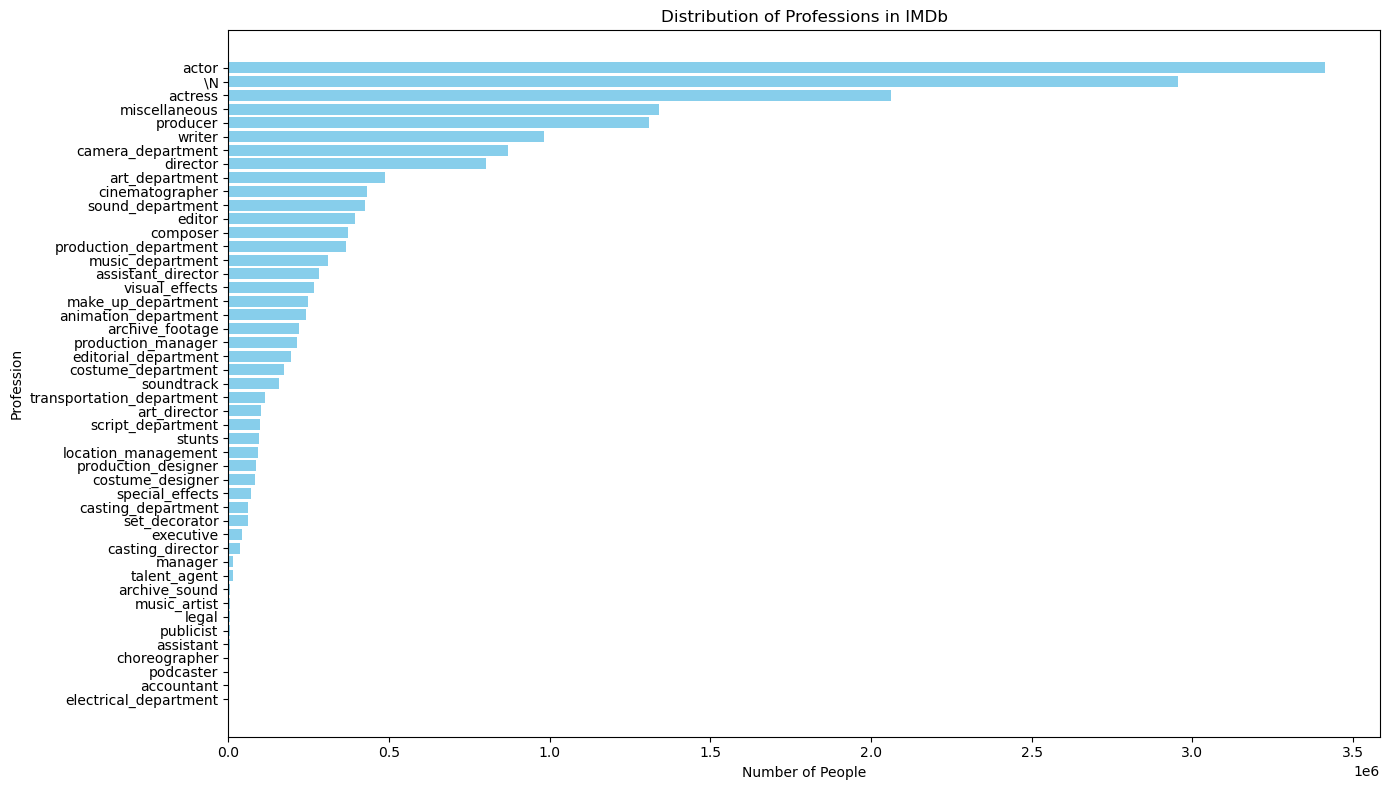

In [344]:
# Making a bar graph with query results
df_prof = con.sql("""
SELECT
    profession,
    COUNT(*) AS total
FROM (
    SELECT unnest(string_split(primaryProfession, ',')) AS profession
    FROM imdb_name_basics
)
GROUP BY profession
ORDER BY total DESC
""").df()

# gráfico
plt.figure(figsize=(14, 8))
plt.barh(df_prof["profession"], df_prof["total"], color="skyblue")
plt.xlabel("Number of People")
plt.ylabel("Profession")
plt.title("Distribution of Professions in IMDb")
plt.gca().invert_yaxis()  # para mostrar a profissão mais comum no topo
plt.tight_layout()
plt.show()


This table seems to be interessent due to the primary key "nconst" that can retrieve the name information in the "primaryName" cell

#### 1.2 File "title.basics.tsv"

In [350]:
# Creating the view for the title.basics file
con.sql(f"""
CREATE OR REPLACE view imdb_title_basics AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.basics.tsv"}', delim='\t', header=TRUE)
""")

In [351]:
con.sql("describe imdb_title_basics").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,titleType,VARCHAR,YES,None,None,None
2,primaryTitle,VARCHAR,YES,None,None,None
3,originalTitle,VARCHAR,YES,None,None,None
4,isAdult,BIGINT,YES,None,None,None
5,startYear,VARCHAR,YES,None,None,None
6,endYear,VARCHAR,YES,None,None,None
7,runtimeMinutes,VARCHAR,YES,None,None,None
8,genres,VARCHAR,YES,None,None,None


In [352]:
con.sql("SELECT * FROM imdb_title_basics LIMIT 10").df()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,\N,1,Short
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport"
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short"
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short"


In [353]:
# How many films does this Db has
con.sql("""
SELECT COUNT(DISTINCT tconst) AS total_titles
FROM imdb_title_basics
""").df()

,total_titles
0,12046631


In [354]:
# How many diferent types of titles this DB has?
con.sql("""
SELECT DISTINCT titleType AS Title_type
FROM imdb_title_basics
""").df()

,Title_type
0,videoGame
1,video
2,short
3,movie
4,tvSpecial
5,tvMiniSeries
6,tvPilot
7,tvMovie
8,tvSeries
9,tvEpisode


#### 1.3 File "title.crew.tsv"

In [355]:
# Creating the view for the title.crew file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_title_crew AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.crew.tsv"}', delim='\t', header=TRUE)
""")

In [356]:
#
con.sql("DESCRIBE imdb_title_crew").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,directors,VARCHAR,YES,None,None,None
2,writers,VARCHAR,YES,None,None,None


In [357]:
# Reviewing some data from the imdb_title_crew table
con.sql("SELECT * FROM imdb_title_crew LIMIT 3").df()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,nm0721526


In [358]:
# How many diferent directors and writers this DB has
con.sql("""
SELECT COUNT(DISTINCT tconst) AS titles_count,COUNT(DISTINCT directors) AS directors_count, COUNT(DISTINCT writers) AS writers_count
FROM imdb_title_crew
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,titles_count,directors_count,writers_count
0,12048919,983105,1461633


Database with important information: Director and writer name by movie.

#### 1.4 File "title.principals.tsv"

In [362]:
# Creating the view for the principals file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_principals AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.principals.tsv"}', delim='\t', header=TRUE)
""")

In [363]:
# Reviewing the structure of the imdb_principals table
con.sql("DESCRIBE imdb_principals").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,ordering,BIGINT,YES,None,None,None
2,nconst,VARCHAR,YES,None,None,None
3,category,VARCHAR,YES,None,None,None
4,job,VARCHAR,YES,None,None,None
5,characters,VARCHAR,YES,None,None,None


In [364]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM imdb_principals LIMIT 500").df()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0005690,producer,producer,\N
3,tt0000001,4,nm0374658,cinematographer,director of photography,\N
4,tt0000002,1,nm0721526,director,\N,\N
...,...,...,...,...,...,...
495,tt0000226,1,nm0378408,producer,producer,\N
496,tt0000227,1,nm4427898,director,\N,\N
497,tt0000227,2,nm0666972,producer,producer,\N
498,tt0000228,1,nm0349785,director,\N,\N


In [365]:
# Count of the different categories and number of occurrences of each one
con.sql("""
SELECT category, COUNT(*) AS total
FROM imdb_principals
GROUP BY category
ORDER BY total DESC
""").df()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,category,total
0,actor,22719012
1,actress,17158284
2,self,14124424
3,writer,11435609
4,director,8212472
5,producer,7156896
6,editor,5053629
7,cinematographer,3863550
8,composer,3096612
9,production_designer,1141840


In [366]:
# Count of the different jobs and number of occurrences of each one
con.sql("""
SELECT job, COUNT(*) AS total
FROM imdb_principals
GROUP BY job
ORDER BY total DESC
""").df()



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,job,total
0,\N,77742195
1,producer,6982719
2,writer,1769000
3,director,874812
4,written by,750320
...,...,...
45677,"song ""Rudolph the Red-Nosed Reindeer""",1
45678,"novel ""Sommeil du mimosa""",1
45679,"inspired by the article ""Zodiac Hunter"" by",1
45680,"short story ""La grande bretèche""",1


#### 1.5 File "title.ratings.tsv"

In [367]:
# Creating the view for the title.episode file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_ratings AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.ratings.tsv"}', delim='\t', header=TRUE)
""")

In [368]:
# Reviewing the structure of the imdb_ratings table
con.sql("DESCRIBE imdb_ratings").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,averageRating,DOUBLE,YES,None,None,None
2,numVotes,BIGINT,YES,None,None,None


In [369]:
# Reviewing some data from the imdb_ratings table
con.sql("SELECT * FROM imdb_ratings LIMIT 10").df()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2183
1,tt0000002,5.5,304
2,tt0000003,6.4,2263
3,tt0000004,5.2,195
4,tt0000005,6.2,3006
5,tt0000006,5.0,220
6,tt0000007,5.3,932
7,tt0000008,5.3,2355
8,tt0000009,5.3,231
9,tt0000010,6.8,8137


In [370]:
# Some statistics about the ratings and votes
con.sql("""
SELECT
    COUNT(*)                        AS total_filmes,
    MIN(averageRating)              AS min_rating,
    MAX(averageRating)              AS max_rating,
    AVG(averageRating)              AS media_rating,
    MIN(numVotes)                   AS min_votes,
    MAX(numVotes)                   AS max_votes,
    AVG(numVotes)                   AS media_votes
FROM imdb_ratings
""").df()


,total_filmes,min_rating,max_rating,media_rating,min_votes,max_votes,media_votes
0,1634484,1.0,10.0,6.928612,5,3116740,1017.511738


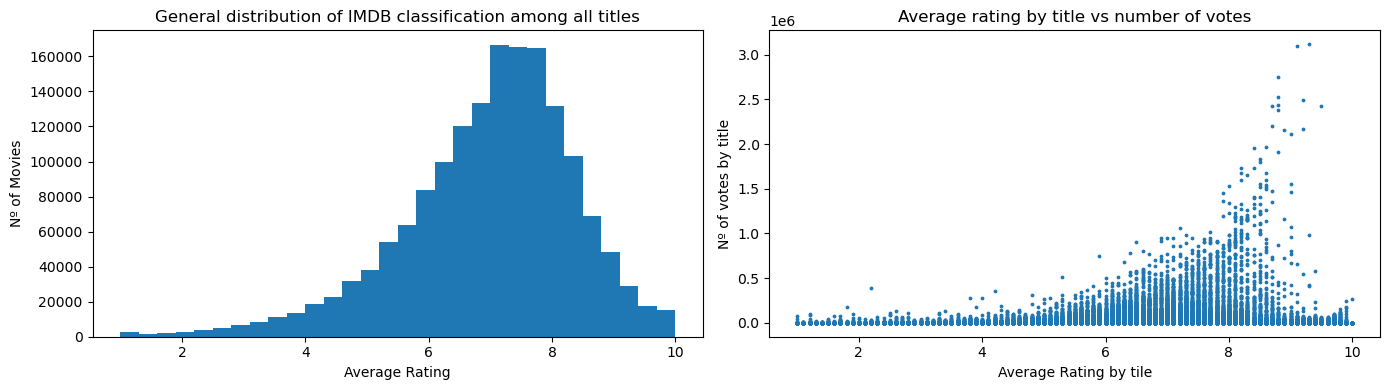

In [371]:
# Visualizing the distribution of ratings and votes
df_ratings = con.sql("SELECT averageRating FROM imdb_ratings").df()
df_votes   = con.sql("SELECT numVotes, averageRating FROM imdb_ratings WHERE numVotes < 50000000000").df()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,4))

# --- gráfic 1: hist rating
axes[0].hist(df_ratings["averageRating"], bins=30)
axes[0].set_title("General distribution of IMDB classification among all titles")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Nº of Movies")

# --- gráfico 2: scatter
axes[1].scatter(df_votes["averageRating"], df_votes["numVotes"], s=3)
axes[1].set_title("Average rating by title vs number of votes")
axes[1].set_xlabel("Average Rating by tile")
axes[1].set_ylabel("Nº of votes by title")

plt.tight_layout()
plt.show()


#### 1.8 Conclusions
Tables form Imdb Dataset:

  - imdb_name_basics: Description of all names of persons in Imdb (pk: nconst):
    - nconst (manter)
    - primaryName  (manter)
    - birthYear
    - deathYear  
    - primaryProfession
    - knownforTitles (manter)

 - imdb_title_akas: table with the diferents names of the titles in diferent countries, table to not be added:
   - titleid
   - ordering
   - title
   - region
   - language
   - types
   - attributes
   - isOriginalTitle

 - imdb_title_basics(manter apenas os "Movies"):
   - tconst (manter apenas a classe movies)
   - titleType
   - primaryTitle
   - originalTitle
   - isAdult
   - startYear (manter apenas a classe movies)
   - endYear
   - runtimeMinutes
   - genres (manter apenas a classe movies)

 - imdb_title_crew(a manter):
   - tconst
   - directors
   - writers

 - imdb_title_episode;
    - tconst
    - parentTconst
    - seasonNumber
    - episodeNumber

 - imdb_principals
    - tconst
    - ordering
    - nconst
    - category
    - job
    - characters

In [372]:
# List of all tables in the database
con.sql("""
SELECT table_name, table_type
FROM information_schema.tables
""").df()

,table_name,table_type
0,links,BASE TABLE
1,movies,BASE TABLE
2,ratings,BASE TABLE
3,tags,BASE TABLE
4,imdb_name_basics,VIEW
5,imdb_principals,VIEW
6,imdb_ratings,VIEW
7,imdb_title_akas,VIEW
8,imdb_title_basics,VIEW
9,imdb_title_crew,VIEW


In [373]:
# How many MovieLens movies have link to imdbId?
con.sql("""
SELECT COUNT(*) AS movielens_movies_count,
       COUNT(imdbId) AS movies_with_link,
       COUNT(*) - COUNT(imdbId) AS movies_without_link
FROM links
""").df()


,movielens_movies_count,movies_with_link,movies_without_link
0,9742,9742,0


### 2.0 Data enrichment with Imdb dataset
#### 2.1 Creation of link table with movies ID (imdb and movielens)

In [374]:
# Df Creation with link between movielens and Imdb links
con.sql("""
CREATE OR REPLACE VIEW imdb_map_ids AS
SELECT
    movieId,
    'tt' || LPAD(imdbId, 7, '0') AS tconst
FROM links
WHERE imdbId IS NOT NULL;
""")

In [375]:
# Reviewing some data from the imdbmaps_ids table
con.sql("SELECT * FROM imdb_map_ids LIMIT 10").df()

,movieId,tconst
0,1,tt0114709
1,2,tt0113497
2,3,tt0113228
3,4,tt0114885
4,5,tt0113041
5,6,tt0113277
6,7,tt0114319
7,8,tt0112302
8,9,tt0114576
9,10,tt0113189


#### 2.2 Creation of table with movielens movie directors

In [376]:
# Creation of table movielens_directors
con.sql("""
CREATE OR REPLACE TABLE movielens_directors AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS director_name
FROM movies AS m
JOIN imdb_map_ids AS map ON map.movieId = m.movieId
JOIN imdb_title_crew AS c ON c.tconst = map.tconst
-- explode comma-separated directors into rows
CROSS JOIN UNNEST(str_split(c.directors, ',')) AS d(director_nconst_raw)
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(d.director_nconst_raw)
WHERE c.directors IS NOT NULL
  AND c.directors <> '';
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [377]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_directors LIMIT 5").df()

,movieId,title,director_name
0,63082,Slumdog Millionaire (2008),Loveleen Tandan
1,59336,Redbelt (2008),David Mamet
2,86721,Idiots and Angels (2008),Bill Plympton
3,79185,Knight and Day (2010),James Mangold
4,67923,"Fast & Furious (Fast and the Furious 4, The) (...",Justin Lin


In [379]:
# Query para determinar quantos fimes do nosso dataset original encontram aqui resposta para o seu director e quantos não encontrma
con.sql("""
WITH t AS (
    SELECT COUNT(*) AS total_movies FROM movies
),
d AS (
    SELECT COUNT(DISTINCT movieId) AS movies_with_director
    FROM movielens_directors
)
SELECT
    t.total_movies,
    d.movies_with_director,
    t.total_movies - d.movies_with_director AS movies_without_director
FROM t, d;
""").df()

,total_movies,movies_with_director,movies_without_director
0,9742,9719,23


In [380]:
# Compute mean, median and mode of number of directors per film
con.sql("""
WITH director_counts AS (
    SELECT
        movieId,
        COUNT(*) AS num_directors
    FROM movielens_directors
    GROUP BY movieId
),
mode_calc AS (
    SELECT
        num_directors,
        COUNT(*) AS freq,
        ROW_NUMBER() OVER (ORDER BY COUNT(*) DESC) AS rn
    FROM director_counts
    GROUP BY num_directors
)
SELECT
    AVG(num_directors) AS mean_directors,
    MEDIAN(num_directors) AS median_directors,
    (SELECT num_directors FROM mode_calc WHERE rn = 1) AS mode_directors
FROM director_counts
        """).df()


,mean_directors,median_directors,mode_directors
0,1.134993,1.0,1


In [381]:
# Movies with more directors
con.sql("""
SELECT
    movieId,
    title,
    COUNT(*) AS num_directors
FROM movielens_directors
GROUP BY movieId, title
HAVING COUNT(*) > 1
ORDER BY num_directors DESC, title;
""").df()


,movieId,title,num_directors
0,100397,"ABCs of Death, The (2012)",27
1,40697,Babylon 5,25
2,171749,Death Note: Desu nôto (2006–2007),21
3,50912,"Paris, I Love You (Paris, je t'aime) (2006)",21
4,68945,Neon Genesis Evangelion: Death & Rebirth (Shin...,15
...,...,...,...
805,163386,Winnie the Pooh and the Day of Concern (1972),2
806,96567,"Words, The (2012)",2
807,45726,"You, Me and Dupree (2006)",2
808,57274,[REC] (2007),2


#### 2.3 Creation of table with movielens movie writers

In [382]:
# Creation of table movielens_writers
con.sql("""
CREATE OR REPLACE TABLE movielens_writers AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS writer_name
FROM movies AS m
JOIN imdb_map_ids AS map
    ON map.movieId = m.movieId
JOIN imdb_title_crew AS c
    ON c.tconst = map.tconst
CROSS JOIN UNNEST(str_split(c.writers, ',')) AS d(writer_nconst_raw)
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(d.writer_nconst_raw)
WHERE c.writers IS NOT NULL
  AND c.writers <> ''
  AND c.writers <> '\\N';
""")


In [383]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_writers LIMIT 5").df()

,movieId,title,writer_name
0,180777,Die Frauen von Ravensbrück (2005),Loretta Walz
1,54185,Manufactured Landscapes (2006),Lucas Lackner
2,65682,Underworld: Rise of the Lycans (2009),Kevin Grevioux
3,97225,Hotel Transylvania (2012),Kevin Hageman
4,55269,"Darjeeling Limited, The (2007)",Jason Schwartzman


In [384]:
# Histogram: number of writers -> number of films
con.sql("""
WITH per_film AS (
  SELECT movieId, COUNT(DISTINCT writer_name) AS num_writers
  FROM movielens_writers
  GROUP BY movieId
)
SELECT num_writers, COUNT(*) AS n_films
FROM per_film
GROUP BY num_writers
ORDER BY num_writers;
""").df()

,num_writers,n_films
0,1,2883
1,2,3094
2,3,1831
3,4,856
4,5,430
5,6,196
6,7,86
7,8,46
8,9,33
9,10,25


In [385]:
# Coverage: how many ML movies have at least one writer mapped vs not
con.sql("""
WITH t AS (
    SELECT COUNT(*) AS total_movies FROM movies
),
w AS (
    SELECT COUNT(DISTINCT movieId) AS movies_with_writer
    FROM movielens_writers
)
SELECT
    t.total_movies,
    w.movies_with_writer,
    t.total_movies - w.movies_with_writer AS movies_without_writer
FROM t, w;
""").df()

,total_movies,movies_with_writer,movies_without_writer
0,9742,9556,186


In [386]:
# Films with more than one writer (list names if you want)
con.sql("""
SELECT
    movieId,
    title,
    COUNT(DISTINCT writer_name) AS num_writers
FROM movielens_writers
GROUP BY movieId, title
HAVING COUNT(DISTINCT writer_name) > 1
ORDER BY num_writers DESC, title;
""").df()


,movieId,title,num_writers
0,1907,Mulan (1998),32
1,364,"Lion King, The (1994)",29
2,50912,"Paris, I Love You (Paris, je t'aime) (2006)",29
3,6889,Brother Bear (2003),27
4,132888,Comedy Central Roast of James Franco (2013),27
...,...,...,...
6668,2698,Zone 39 (1997),2
6669,60885,"Zone, The (La Zona) (2007)",2
6670,156553,Zoom (2015),2
6671,5899,Zulu (1964),2


This table does not make sense. After visiting IMDB page is undertanded that there are several diferent writers but only one general wrting. 

link: https://www.imdb.com/title/tt0120762/fullcredits/?ref_=tt_ov_sm_2#amzn1.imdb.concept.name_credit_category.c84ecaff-add5-4f2e-81db-102a41881fe3
 

In [387]:
# Top writers by number of films
top_writers = con.sql("""
    SELECT
        writer_name,
        COUNT(*) AS total_films
    FROM movielens_writers
    WHERE writer_name IS NOT NULL
      AND writer_name <> ''
    GROUP BY writer_name
    ORDER BY total_films DESC
    LIMIT 20  -- change this value if you want a longer/shorter top
""").df()

top_writers


,writer_name,total_films
0,Woody Allen,51
1,Stephen King,47
2,Jack Kirby,37
3,Luc Besson,37
4,Ben Hecht,32
5,Stan Lee,32
6,William Shakespeare,32
7,John Hughes,32
8,Bob Kane,29
9,Ian Fleming,26


#### 2.4 Creation of table with movielens_actors

In [388]:
#criação da tabela movielens_actors
con.sql("""
CREATE OR REPLACE TABLE movielens_actors AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName     AS actor_name,
    p.category,
    p.characters
FROM movies m
JOIN imdb_map_ids map ON map.movieId = m.movieId
JOIN imdb_principals p ON p.tconst = map.tconst
LEFT JOIN imdb_name_basics nb ON nb.nconst = p.nconst
WHERE p.category IN ('actor', 'actress');
""")

#remoção dos caracteres que nao queremos [" e "]:
con.sql("""
UPDATE movielens_actors
SET characters = REGEXP_REPLACE(characters, '[\\[\\]\"]', '', 'g')
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [389]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_actors LIMIT 5").df()

,movieId,title,actor_name,category,characters
0,7842,Dune (2000),James Watson,actor,Duncan Idaho
1,7842,Dune (2000),Jan Vlasák,actor,Thufir Hawat
2,7842,Dune (2000),P.H. Moriarty,actor,Gurney Halleck
3,7842,Dune (2000),Robert Russell,actor,Dr. Yueh
4,7842,Dune (2000),Laura Burton,actress,Alia Atreides


In [390]:
#remoção dos caracteres que nao queremos [" e "]:
con.sql("""
UPDATE movielens_actors
SET characters = REGEXP_REPLACE(characters, '[\\[\\]\"]', '', 'g')
""")


In [391]:
#Preview da tabela
con.sql("SELECT * FROM movielens_actors LIMIT 500").df()

,movieId,title,actor_name,category,characters
0,7842,Dune (2000),James Watson,actor,Duncan Idaho
1,7842,Dune (2000),Jan Vlasák,actor,Thufir Hawat
2,7842,Dune (2000),P.H. Moriarty,actor,Gurney Halleck
3,7842,Dune (2000),Robert Russell,actor,Dr. Yueh
4,7842,Dune (2000),Laura Burton,actress,Alia Atreides
...,...,...,...,...,...
495,3720,Sunshine (1999),Miriam Margolyes,actress,Rose Sonnenschein
496,2840,Stigmata (1999),Patricia Arquette,actress,Frankie Paige
497,2840,Stigmata (1999),Gabriel Byrne,actor,Father Andrew Kiernan
498,2840,Stigmata (1999),Jonathan Pryce,actor,Cardinal Daniel Houseman


In [392]:
#Top 20 most common character names
con.sql("""
SELECT
    characters,
    COUNT(*) AS n_rows
FROM movielens_actors
GROUP BY characters
ORDER BY n_rows DESC
LIMIT 20;
""").df()


,characters,n_rows
0,\N,500
1,Narrator,211
2,Jack,115
3,Sam,113
4,Frank,112
5,Paul,101
6,John,92
7,Max,85
8,Sarah,85
9,Charlie,84


In [395]:
#Actors who played more than one character in the same movie
con.sql("""
WITH per_actor AS (
    SELECT
        movieId,
        actor_name,
        COUNT(DISTINCT characters) AS num_characters
    FROM movielens_actors
    WHERE characters IS NOT NULL AND characters <> ''
    GROUP BY movieId, actor_name
)
SELECT *
FROM per_actor
WHERE num_characters > 1
ORDER BY num_characters DESC, actor_name;
""").df()


,movieId,actor_name,num_characters
0,95004,Adam Baldwin,3
1,5879,Adam Sandler,3
2,139640,Aileen Mythen,3
3,48045,Alain Chabat,3
4,6639,Alan Arkin,3
...,...,...,...
2416,31610,Ziyi Zhang,2
2417,113394,Zoe Kazan,2
2418,90809,Zoé Héran,2
2419,126142,Ángela Molina,2


In [396]:
#Actors who played Batman (any variation, case insensitive)
con.sql("""
SELECT DISTINCT movieId, title, actor_name, characters
FROM movielens_actors
WHERE characters ILIKE '%batman%'
ORDER BY title, actor_name;
""").df()


,movieId,title,actor_name,characters
0,6620,American Splendor (2003),Joey Krajcar,Batman
1,1562,Batman & Robin (1997),George Clooney,Batman
2,26152,Batman (1966),Adam West,Batman
3,592,Batman (1989),Michael Keaton,Batman
4,33794,Batman Begins (2005),Christian Bale,Batman
5,27311,Batman Beyond: Return of the Joker (2000),Will Friedle,Batman
6,153,Batman Forever (1995),Val Kilmer,Batman
7,1377,Batman Returns (1992),Michael Keaton,Batman
8,136864,Batman v Superman: Dawn of Justice (2016),Ben Affleck,Batman
9,131739,Batman vs. Robin (2015),Jason O'Mara,Batman


In [398]:
# Top actors who played Batman (by number of distinct films)
con.sql("""
SELECT
  actor_name,
  COUNT(DISTINCT movieId) AS films_as_batman
FROM movielens_actors
WHERE characters ILIKE '%Batman%'
GROUP BY actor_name
ORDER BY films_as_batman DESC, actor_name;
""").df()


,actor_name,films_as_batman
0,Kevin Conroy,8
1,Ben Affleck,2
2,Michael Keaton,2
3,Peter Weller,2
4,Will Arnett,2
5,Adam West,1
6,Ben McKenzie,1
7,Bruce Greenwood,1
8,Christian Bale,1
9,George Clooney,1


In [400]:
con.sql("SHOW TABLES").df()

,name
0,imdb_map_ids
1,imdb_name_basics
2,imdb_principals
3,imdb_ratings
4,imdb_title_akas
5,imdb_title_basics
6,imdb_title_crew
7,imdb_title_episode
8,links
9,links_norm


#### 2.5 Criação de tabela com avaliação os ratings e votos do imdb

In [401]:
# IMDb ratings mapped to MovieLens movieId
con.sql("""
CREATE OR REPLACE TABLE movielens_ratings_imdb AS
SELECT
    m.movieId,
    r.numVotes,
    r.averageRating
FROM movies m
JOIN imdb_map_ids map ON map.movieId = m.movieId
LEFT JOIN imdb_ratings r ON r.tconst = map.tconst
""")


In [402]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_ratings_imdb LIMIT 5").df()

,movieId,numVotes,averageRating
0,149380,2215,6.3
1,159161,8340,7.5
2,148667,10018,7.9
3,168090,3975,7.6
4,168218,4045,7.8


In [ ]:
con.sql("""
SELECT
    COUNT(*) AS total,
    COUNT(averageRating) AS with_rating,
    COUNT(*) - COUNT(averageRating) AS without_rating
FROM movielens_ratings_imdb
""").df()


In [ ]:
# Sample top by votes
con.sql("""
SELECT *
FROM movielens_ratings_imdb
WHERE numVotes IS NOT NULL
ORDER BY numVotes DESC
LIMIT 10
""").df()


#### Fechar a ligação

In [ ]:
con.close()
print("Ligação fechada.")